In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import requests
import QuantLib as ql
import numpy as np
import json
from tradingview_screener import Query, col
import rookiepy
from sklearn.preprocessing import MinMaxScaler
import gbm_optimizer
from gbm_optimizer import optimize_gbm, gbm
import matplotlib.pyplot as plt
from arch import arch_model
from yahooquery import Ticker


import importlib
importlib.reload(gbm_optimizer)


with open("config.json", "r") as config_file:
    config = json.load(config_file)

api_key = config.get("api_key")
secret_key = config.get("secret_key")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

our_picks = ["CHWY", "IBIT", "ASO", "MARA", "ET", "DVN", "INTC", "SPLG", "TOST", "NBIS", "ON"]
too_expensive = ["HIMS", "TEM"]


In [7]:
    
def screen_stocks():
    # Get cookies for TradingView session
    cookies = rookiepy.to_cookiejar(rookiepy.chrome(['.tradingview.com']))
    
    _, df = Query().select('close','change', 'Perf.3M', 'Perf.6M').where(
        col('close').between(20, 50),
        col('change').between(-4,-2),
        col('Perf.3M') > 0,
        col('Perf.6M') > 5,
        col('exchange').isin(['AMEX', 'NASDAQ', 'NYSE']),

        ).limit(1000).get_scanner_data(cookies=cookies)
    
    df[['exchange', 'ticker']] = df['ticker'].str.split(':', expand=True)
    
    return df


def get_current_stock_price(symbol: str):

    url = "https://data.alpaca.markets/v2/stocks/trades/latest"

    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": api_key,
        "APCA-API-SECRET-KEY": secret_key,
    }

    params = {
        "symbols": symbol,  
        "feed": "iex" 
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()  

        data = response.json()

        return data.get("trades", {}).get(symbol, {}).get("p") 

    except requests.exceptions.RequestException as e:
        print(f"Error fetching stock price: {e}")



def get_option_chain(symbol, option_type="puts", expiration_date=None):
    """
    Fetches the option chain for a given stock symbol using yahooquery.

    :param symbol: Stock ticker symbol (e.g., "AAPL").
    :param option_type: 'calls', 'puts', or None (default: both calls and puts).
    :param expiration_date: Specific expiration date (e.g., '2025-03-21') or None to get all available expirations.
    :return: pandas DataFrame containing the option chain.
    """
    try:
        stock = Ticker(symbol)
        df = stock.option_chain  # Fetch all available option chain data

        if df is None or df.empty:
            print(f"No option data available for {symbol}.")
            return None

        # Filter by expiration date if provided
        if expiration_date:
            df = df.loc[df.index.get_level_values('expiration') == expiration_date]

        # Filter by option type if provided ('calls' or 'puts')
        if option_type in ['calls', 'puts']:
            df = df.xs(option_type, level=2)

        # Reset index to remove multi-indexing
        df = df.reset_index()

        # Rename 'expiration' to 'expiration_date'
        df = df.rename(columns={'expiration': 'expiration_date'})

        # Calculate ROI as (bid + ask) / strike * 100
        df['mid_price'] = (df['bid'] + df['ask']) / 2
        df['ROI'] = (df['mid_price'] / df['strike']) * 100
        

        # Filter rows based on open interest, bid, in-the-money, and ROI
        df = df[(df['openInterest'] >= 50) & 
                (df['bid'] > 0.00) & 

                (df['ROI'] > 0.1) &
                (((df['ask'] - df['bid']) / df['bid']) * 100 < 40)
                ] 

        return df

    except Exception as e:
        print(f"Error fetching option chain: {e}")
        return None


def select_optimal_contract(contracts):
    """Compute the weighted score for contracts using normalized values."""
    temp_contracts = contracts.copy()
    
    scaler = MinMaxScaler()
    temp_contracts[['profitability_likelihood', 'ROI', 'sortino_ratio']] = scaler.fit_transform(
        temp_contracts[['profitability_likelihood', 'ROI', 'sortino_ratio']]
    )
    
    temp_contracts['score'] = (
        0.60 * temp_contracts['profitability_likelihood'] +
        0.40 * temp_contracts['ROI'] +
        0.10 * temp_contracts['sortino_ratio']
    )
    
    contracts['score'] = temp_contracts['score']
    
    return contracts.sort_values(by='score', ascending=False)


def audit_stocks(expiration_date: datetime, tickers: list = None):

    all_options = []

    # Determine which stocks to audit
    if tickers is None or not tickers:
        tickers = screen_stocks()['ticker'].to_list()
        tickers.extend(our_picks)

    # print(f"Auditing {len(tickers)} stocks: {tickers}")

    for ticker in tickers:
        put_chain = audit_single_ticker(ticker=ticker, expiration_date=expiration_date)
        if not put_chain.empty:
            all_options.append(put_chain)

    # Combine all results into a single DataFrame
    if all_options:
        result_df = pd.concat(all_options, ignore_index=True)
        return result_df

    return pd.DataFrame()


def audit_single_ticker(ticker: str, expiration_date: datetime):
    # T-bill 3-month rate: 4.19%, scaled to daily compounding
    daily_risk_free_rate = (1 + 0.0419) ** (1/252) - 1

    simulation_attempts = 500
    optimizer_training_period = "6mo"
    bin_length = 18
    days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

    option_chain = get_option_chain(symbol=ticker, expiration_date=expiration_date)

    if option_chain is None or option_chain.empty:
        print(f"No options available for {ticker} on {expiration_date}")
        return pd.DataFrame()

    price = get_current_stock_price(ticker)

    optimized_mu, optimized_sigma = optimize_gbm(symbol=ticker, training_period=optimizer_training_period, bin_length=bin_length)
    optimized_sigma = fit_garch(symbol=ticker, period=optimizer_training_period)

    # gbm_vs_real_graph(symbol=ticker, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

    put_chain = option_chain.copy()

    for index, contract in put_chain.iterrows():
        strike_price = contract['strike']
        mid_price = (contract['bid'] + contract['ask']) / 2
        simulated_returns = []
        simulated_final_prices = []
        profitable_count = 0

        for _ in range(simulation_attempts):
            prices = gbm(s0=price, mu=optimized_mu, sigma=optimized_sigma, deltaT=days_to_expiration, dt=1)
            final_price = prices[-1]

            # Option expires worthless or at-the-money
            if final_price >= strike_price:
                profitable_count += 1
                net_return = (mid_price / strike_price) * 100
            else:
                # Assigned: premium - (loss from assignment)
                net_return = ((mid_price - (strike_price - final_price)) / strike_price) * 100

            simulated_returns.append(net_return)
            simulated_final_prices.append(final_price)

        profitability_chance = (profitable_count / simulation_attempts) * 100
        avg_return = np.mean(simulated_returns)
        avg_price = np.mean(simulated_final_prices)
        risk_free_return = daily_risk_free_rate * days_to_expiration

        downside_returns = [r for r in simulated_returns if r < risk_free_return]
        downside_std = np.std(downside_returns, ddof=1) if len(downside_returns) > 1 else 0

        sortino_ratio = ((avg_return - risk_free_return) / downside_std) * np.sqrt(252 / days_to_expiration) if downside_std else 0

        put_chain.at[index, 'current_price'] = price
        put_chain.at[index, 'final_price'] = avg_price
        put_chain.at[index, 'profitability_likelihood'] = profitability_chance
        put_chain.at[index, 'average_roi'] = avg_return
        put_chain.at[index, 'sortino_ratio'] = sortino_ratio

    put_chain.drop(columns=['contractSymbol','currency','contractSize', 'lastTradeDate', 'impliedVolatility'], errors='ignore', inplace=True)

    put_chain = put_chain[(put_chain['inTheMoney'] != True) & (put_chain['ROI'] <= 4.0)]

    return put_chain


def fit_garch(symbol, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False, auto_adjust=False)
    real_prices = stock_data["Close"].dropna().values.flatten()
    returns = np.diff(np.log(real_prices))
    
    # Fit GARCH(1,1) model
    model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    garch_fit = model.fit(disp="off")
    
    conditional_volatilities = garch_fit.conditional_volatility

    N = len(conditional_volatilities)
    weights = np.linspace(1, 2, N)  

    weighted_volatility = np.sum(weights * conditional_volatilities) / np.sum(weights)

    return weighted_volatility

def gbm_vs_real_graph(symbol, mu, sigma, period):
    stock_data = yf.download(symbol, period=period, interval="1d", progress=False)
    real_prices = stock_data["Close"].dropna().values
    time_steps = np.arange(len(real_prices))


    gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
    plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
    plt.xlabel("Time (Days)")
    plt.ylabel("Price")
    plt.title(f"GBM vs Real Prices for {symbol}")
    plt.legend()
    plt.grid()
    plt.show()



In [8]:
# Analyze a bunch of stocks
# contracts = audit_csps(expiration_date = datetime(year=2025, month=2, day=21))

# Analyze one stock
# contracts = audit_stocks(tickers=["NBIS"], expiration_date=datetime(year=2025, month=5, day=30))

stocks = screen_stocks()
print(stocks)

  ticker    close    change    Perf.3M    Perf.6M exchange
0   CELH  35.2400 -3.663204   3.312811  20.437457   NASDAQ
1     MT  30.1400 -2.269780   6.126761  20.947030     NYSE
2    GSL  24.8000 -3.313840   7.498916  11.510791     NYSE
3   BTSG  23.1100 -2.653749  13.451154  22.469528   NASDAQ
4   STVN  23.4200 -2.375990  14.299658  19.246436     NYSE
5   ESEA  38.1109 -2.154300  37.143032  19.973820   NASDAQ
6   SNWV  30.4300 -2.467949  13.122677  41.534884   NASDAQ
7  AKO.A  20.2000 -3.349282  30.575307  53.612167     NYSE


In [5]:
contracts = select_optimal_contract(contracts)


display(contracts)


KeyError: "None of [Index(['profitability_likelihood', 'ROI', 'sortino_ratio'], dtype='object')] are in the [columns]"

Analysis for NBIS:
Trend Direction: Strong Uptrend
Entry Signal: No
Bottom Confirmation: No
Recommendation: WAIT


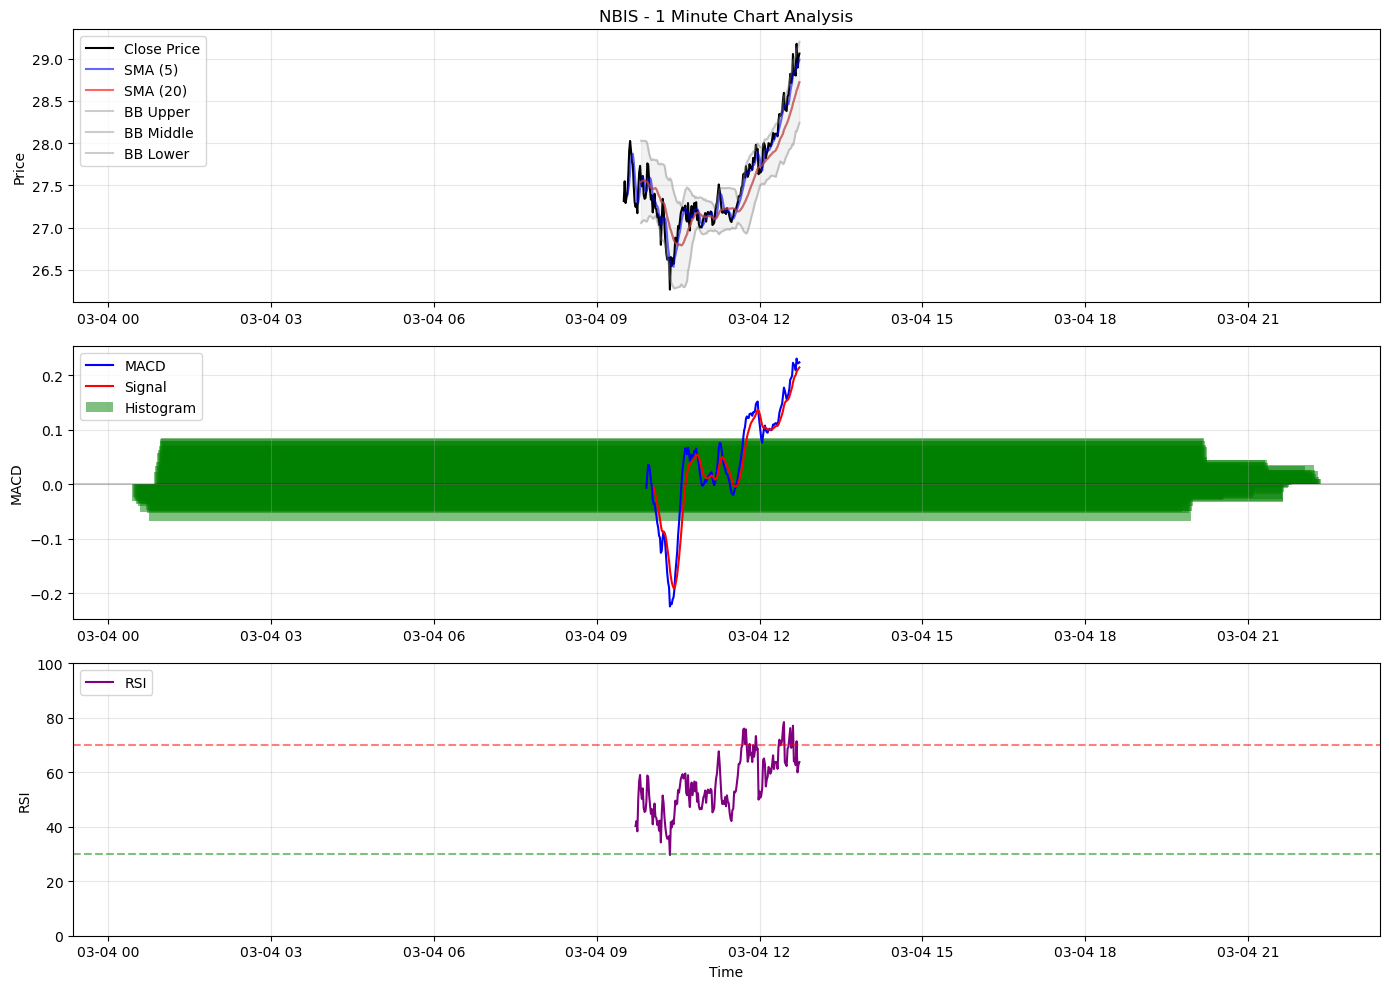

In [2]:
import pandas as pd
import numpy as np
from yahooquery import Ticker
import datetime as dt
import matplotlib.pyplot as plt
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

def analyze_stock_trend(ticker_symbol, lookback_days=1):
    """
    Analyzes 1-minute candlesticks for a given stock to determine trend direction
    and identify potential entry points when price has bottomed out.
    
    Parameters:
    ticker_symbol (str): Stock ticker symbol (e.g., 'AAPL')
    lookback_days (int): Number of trading days to look back (default: 1)
    
    Returns:
    dict: Analysis results including trend direction and entry signal
    """
    # Calculate start date based on lookback period
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=lookback_days)
    
    # Fetch 1-minute candlestick data
    ticker = Ticker(ticker_symbol)
    data = ticker.history(period='1d', interval='1m')
    
    # Reset index to make date a column and keep only relevant columns
    data = data.reset_index()
    data = data[['date', 'open', 'high', 'low', 'close', 'volume']]
    
    # Calculate technical indicators
    # 1. Moving Averages
    data['sma_fast'] = SMAIndicator(close=data['close'], window=5).sma_indicator()
    data['sma_slow'] = SMAIndicator(close=data['close'], window=20).sma_indicator()
    data['ema_fast'] = EMAIndicator(close=data['close'], window=9).ema_indicator()
    data['ema_slow'] = EMAIndicator(close=data['close'], window=21).ema_indicator()
    
    # 2. MACD
    macd = MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()
    
    # 3. RSI
    data['rsi'] = RSIIndicator(close=data['close'], window=14).rsi()
    
    # 4. Bollinger Bands
    bollinger = BollingerBands(close=data['close'], window=20, window_dev=2)
    data['bb_upper'] = bollinger.bollinger_hband()
    data['bb_middle'] = bollinger.bollinger_mavg()
    data['bb_lower'] = bollinger.bollinger_lband()
    data['bb_width'] = (data['bb_upper'] - data['bb_lower']) / data['bb_middle']
    
    # Determine trend direction based on multiple indicators
    # Look at the most recent data points
    recent_data = data.tail(30)
    
    # Trend determination
    sma_trend = 1 if recent_data['sma_fast'].iloc[-1] > recent_data['sma_slow'].iloc[-1] else -1
    ema_trend = 1 if recent_data['ema_fast'].iloc[-1] > recent_data['ema_slow'].iloc[-1] else -1
    macd_trend = 1 if recent_data['macd'].iloc[-1] > recent_data['macd_signal'].iloc[-1] else -1
    
    # Overall trend score (-3 to 3, higher is more bullish)
    trend_score = sma_trend + ema_trend + macd_trend
    
    # Entry point detection (bottoming out)
    entry_signal = False
    entry_strength = 0
    
    # Check for potential reversal signals
    # 1. RSI oversold and starting to rise
    if (recent_data['rsi'].iloc[-2] < 30 and recent_data['rsi'].iloc[-1] > recent_data['rsi'].iloc[-2]):
        entry_signal = True
        entry_strength += 1
    
    # 2. Price near or below lower Bollinger Band
    if (recent_data['close'].iloc[-1] <= recent_data['bb_lower'].iloc[-1] * 1.01):
        entry_signal = True
        entry_strength += 1
    
    # 3. MACD histogram starting to rise from negative territory
    if (recent_data['macd_diff'].iloc[-2] < 0 and 
        recent_data['macd_diff'].iloc[-1] > recent_data['macd_diff'].iloc[-2]):
        entry_signal = True
        entry_strength += 1
    
    # 4. Volume increasing (possible accumulation)
    vol_avg = recent_data['volume'].iloc[-6:-1].mean()
    if recent_data['volume'].iloc[-1] > vol_avg * 1.2:
        entry_strength += 1
    
    # Generate analysis results
    if trend_score >= 2:
        trend_direction = "Strong Uptrend"
    elif trend_score > 0:
        trend_direction = "Weak Uptrend"
    elif trend_score == 0:
        trend_direction = "Sideways/Neutral"
    elif trend_score > -2:
        trend_direction = "Weak Downtrend"
    else:
        trend_direction = "Strong Downtrend"
    
    # Check for bottom confirmation based on trend and entry signals
    bottom_confirmation = False
    if trend_score >= 0 and entry_signal and entry_strength >= 2:
        bottom_confirmation = True
    elif trend_score < 0 and entry_signal and entry_strength >= 3:
        bottom_confirmation = True
    
    # Create analysis result
    analysis_result = {
        'ticker': ticker_symbol,
        'last_price': data['close'].iloc[-1],
        'trend_direction': trend_direction,
        'trend_score': trend_score,
        'entry_signal': entry_signal,
        'entry_strength': entry_strength,
        'bottom_confirmation': bottom_confirmation,
        'recommendation': "BUY" if bottom_confirmation else "WAIT",
        'timestamp': dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    
    return analysis_result, data

def plot_analysis(data, ticker_symbol):
    """
    Plots the analysis results including price, indicators, and signals.
    
    Parameters:
    data (DataFrame): The dataframe with calculated indicators
    ticker_symbol (str): Stock ticker symbol for plot title
    """
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Price with MA and Bollinger Bands
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(data['date'], data['close'], label='Close Price', color='black')
    ax1.plot(data['date'], data['sma_fast'], label='SMA (5)', color='blue', alpha=0.6)
    ax1.plot(data['date'], data['sma_slow'], label='SMA (20)', color='red', alpha=0.6)
    ax1.plot(data['date'], data['bb_upper'], label='BB Upper', color='gray', alpha=0.4)
    ax1.plot(data['date'], data['bb_middle'], label='BB Middle', color='gray', alpha=0.4)
    ax1.plot(data['date'], data['bb_lower'], label='BB Lower', color='gray', alpha=0.4)
    ax1.fill_between(data['date'], data['bb_upper'], data['bb_lower'], alpha=0.1, color='gray')
    ax1.set_title(f'{ticker_symbol} - 1 Minute Chart Analysis')
    ax1.set_ylabel('Price')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Plot 2: MACD
    ax2 = plt.subplot(3, 1, 2, sharex=ax1)
    ax2.plot(data['date'], data['macd'], label='MACD', color='blue')
    ax2.plot(data['date'], data['macd_signal'], label='Signal', color='red')
    ax2.bar(data['date'], data['macd_diff'], label='Histogram', color='green', alpha=0.5)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    ax2.set_ylabel('MACD')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    
    # Plot 3: RSI
    ax3 = plt.subplot(3, 1, 3, sharex=ax1)
    ax3.plot(data['date'], data['rsi'], label='RSI', color='purple')
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5)
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5)
    ax3.fill_between(data['date'], 30, data['rsi'], where=(data['rsi'] < 30), color='green', alpha=0.3)
    ax3.fill_between(data['date'], 70, data['rsi'], where=(data['rsi'] > 70), color='red', alpha=0.3)
    ax3.set_ylabel('RSI')
    ax3.set_xlabel('Time')
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left')
    
    plt.tight_layout()
    return plt

ticker_symbol = 'NBIS'  # Example ticker
analysis_result, data = analyze_stock_trend(ticker_symbol)

# Print analysis
print(f"Analysis for {ticker_symbol}:")
print(f"Trend Direction: {analysis_result['trend_direction']}")
print(f"Entry Signal: {'Yes' if analysis_result['entry_signal'] else 'No'}")
print(f"Bottom Confirmation: {'Yes' if analysis_result['bottom_confirmation'] else 'No'}")
print(f"Recommendation: {analysis_result['recommendation']}")

# Plot the analysis
plot = plot_analysis(data, ticker_symbol)
plot.show()

In [1]:
# Archive

# def audit_csps(expiration_date: datetime):
#     # t-bill 3-month rate: 4.19% and inflation: 2.9%, scaled to daily compounding
#     daily_risk_free_rate = (1 + 0.0419) ** (1/252) - 1  # No inflation adjustment

#     # function hyperparameters
#     simulation_attempts = 300
#     optimizer_training_period = "6mo"
#     bin_length = 18
#     days_to_expiration = np.busday_count(datetime.today().date(), expiration_date.date())

#     all_options = []  
    
#     candidates = screen_stocks()['ticker'].to_list()
#     candidates.extend(our_picks)    

#     print(f"Consider {len(candidates)} stocks")

#     for symbol in candidates:
#         option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=symbol, expiration_date=expiration_date)

#         if option_chain is None or option_chain.empty:
#             continue

#         price = get_current_stock_price(symbol)
#         optimized_mu, optimized_sigma = optimize_gbm(symbol=symbol, training_period=optimizer_training_period, bin_length=bin_length)
#         optimized_sigma = fit_garch(symbol=symbol, period=optimizer_training_period)

#         gbm_vs_real_graph(symbol=symbol, mu=optimized_mu, sigma=optimized_sigma, period=optimizer_training_period)

#         put_chain_copy = option_chain.copy()

#         for index, contract in put_chain_copy.iterrows():
#             strike_price = contract['strike_price']
#             mid_price = contract['mid_price']
#             simulated_returns = []
#             simulated_final_prices = []
#             profitable_count = 0

#             # Run simulations
#             for _ in range(simulation_attempts):
#                 prices = gbm(
#                     s0=price, mu=optimized_mu, sigma=optimized_sigma, 
#                     deltaT=days_to_expiration, 
#                     dt=1
#                 )
#                 final_price = prices[-1]
#                 # option expires worthless (or at-the-money), seller keeps premium.
#                 if final_price >= strike_price:
#                     profitable_count += 1
#                     net_return = (mid_price / strike_price) * 100
#                 else:
#                     # assigned, the net return is: premium - (loss from assignment)
#                     net_return = ((mid_price - (strike_price - final_price)) / strike_price) * 100

#                 simulated_returns.append(net_return)
#                 simulated_final_prices.append(prices[-1])

#             profitability_chance = (profitable_count / simulation_attempts) * 100
#             percent_return = (mid_price / strike_price) * 100  
#             avg_return = np.mean(simulated_returns)
#             avg_price = np.mean(simulated_final_prices)
            
#             risk_free_return = daily_risk_free_rate * days_to_expiration
#             # Downside returns: only include simulated returns that are below the target.
#             downside_returns = [r for r in simulated_returns if r < risk_free_return]
#             if len(downside_returns) > 1:
#                 downside_std = np.std(downside_returns, ddof=1)
#             else:
#                 downside_std = 0

#             # Annualize the ratio (using sqrt(252/days_to_expiration))
#             if downside_std != 0:
#                 sortino_ratio = ((avg_return - risk_free_return) / downside_std) * np.sqrt(252 / days_to_expiration)
#             else:
#                 sortino_ratio = 0

#             put_chain_copy.at[index, 'mid'] = mid_price
#             put_chain_copy.at[index, 'current_price'] = price
#             put_chain_copy.at[index, 'final_price'] = avg_price
#             put_chain_copy.at[index, 'profitability_likelihood'] = profitability_chance
#             put_chain_copy.at[index, 'return_percent'] = percent_return
#             put_chain_copy.at[index, 'average_return'] = avg_return
#             put_chain_copy.at[index, 'sortino_ratio'] = sortino_ratio

#         all_options.append(put_chain_copy)

#     # Concatenate all DataFrames in the list once at the end
#     result_df = pd.concat(all_options, ignore_index=True)

#     # Drop unnecessary columns and reorder at the end
#     result_df.drop(columns=['inTheMoney','contractSymbol','currency','contractSize', 'lastTradeDate', 'impliedVolatility'], errors='ignore', inplace=True)

#     return result_df



# def get_open_interest(api_key: str, secret_key: str, option_symbol: str):
#     """Fetches open interest for a given option contract using Alpaca's Trading API."""
#     url = f"https://paper-api.alpaca.markets/v2/options/contracts/{option_symbol}"
#     headers = {
#         "accept": "application/json",
#         "APCA-API-KEY-ID": api_key,
#         "APCA-API-SECRET-KEY": secret_key,
#     }

#     try:
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#         data = response.json()
#         return data.get("open_interest")  # Extract OI if available
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching open interest for {option_symbol}: {e}")
#         return None

# def get_option_chain(api_key: str, secret_key: str, ticker: str, expiration_date: datetime):
#     expiration_str = expiration_date.strftime("%Y-%m-%d")  
#     data = yf.download(tickers=ticker, period="6mo", interval="1d", progress=False)

#     if len(data) == 0:
#         return None
    
#     url = f"https://data.alpaca.markets/v1beta1/options/snapshots/{ticker}?feed=indicative&limit=100&expiration_date={expiration_str}"
#     headers = {
#         "accept": "application/json",
#         "APCA-API-KEY-ID": api_key,
#         "APCA-API-SECRET-KEY": secret_key,
#     }

#     try:
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#         data = response.json()
#         option_chain = data.get("snapshots", {})

#         parsed_data = []
#         for symbol, details in option_chain.items():
#             expiration_start = len(symbol) - 15
#             option_type = "Call" if symbol[expiration_start+6] == "C" else "Put"
#             strike_price = int(symbol[expiration_start+7:]) / 1000  

#             greeks = details.get("greeks", {}) or {}
#             latest_quote = details.get("latestQuote", {})

#             returned = ((latest_quote.get("ap") + latest_quote.get("bp") / 2) / strike_price) * 100
        
            
#             # if latest_quote.get("ap") == 0 or latest_quote.get("bp") == 0:
#             #     continue
            
#             # if (((latest_quote.get("ap") - latest_quote.get("bp")) / latest_quote.get("bp")) * 100 > 40) or greeks.get("delta") is None or returned < 0.3 or returned > 3.5:
#             #     continue
#             # print("after prices")

#             open_interest = get_open_interest(api_key, secret_key, symbol)
#             open_interest = int(open_interest) if open_interest is not None else 0

#             # if (open_interest < 40):
#             #     continue
            
#             parsed_data.append({
#                 "symbol": ticker,
#                 "expiration_date": expiration_str,  
#                 "option_type": option_type,
#                 "delta": greeks.get("delta"),
#                 "gamma": greeks.get("gamma"),
#                 "rho": greeks.get("rho"),
#                 "theta": greeks.get("theta"),
#                 "vega": greeks.get("vega"),
#                 "implied_volatility": details.get("impliedVolatility"),
#                 "ask_price": latest_quote.get("ap"),
#                 "ask_size": latest_quote.get("as"),
#                 "bid_price": latest_quote.get("bp"),
#                 "bid_size": latest_quote.get("bs"),
#                 "mid_price": (latest_quote.get("bp") + latest_quote.get("ap")) / 2,
#                 "open_interest": open_interest,
#                 "strike_price": strike_price 

#             })

#         print("parsed", parsed_data)
#         df = pd.DataFrame(parsed_data)
#         print("df\n", df)
#         if len(df) == 0: 
#             return None
        
#         df = df[(df['option_type'] == 'Put')]
        
#         return df


    
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching option chain: {e}")
#         return None


# def get_rolling_price_change_avg(ticker: str, days: int):
#     try:
#         end_date = datetime.now()
#         start_date = end_date - timedelta(days=days+10)
        
#         data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
#         if data.empty:
#             return None
        
#         data = data.sort_index()
#         current_price = get_current_stock_price(ticker)

#         data['Price_Change'] = ((current_price - data['Close'].shift(1)) / data['Close'].shift(1)) * 100

#         rolling_avg = data['Price_Change'].rolling(window=min(days, len(data))).mean().iloc[-1]

#         return rolling_avg
    
#     except Exception as e:
#         print(f"Error occurred for ticker {ticker}: {e}")
#         return None, None


# def aobjective(params, real_prices, s0):
#     """Objective function for optimization."""
#     mu, sigma = params  # Unpack parameters
#     gbm_prices = gbm(s0, mu, sigma, deltaT=len(real_prices), dt=1)
#     return mean_squared_error(real_prices, gbm_prices)

# def aoptimize_gbm(symbol: str, training_period: str, bin_length: int):
#     """
#     Optimize μ and σ over multiple time bins, weighting recent periods more.
#     """
#     # Fetch real stock data (past 5 years)
#     stock_data = yf.download(symbol, period=training_period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values

#     num_bins = len(real_prices) // bin_length
#     weights = np.linspace(1, 2, num_bins)  # Increasing weights for recent bins

#     mu_values, sigma_values, mses = [], [], []

#     for i in range(num_bins):
#         bin_prices = real_prices[i * bin_length : (i + 1) * bin_length]
#         s0 = bin_prices[0]

#         bounds = [(-0.3, 0.3), (0.001, 0.35)]

#         result = differential_evolution(objective, bounds, args=(bin_prices, s0))
#         best_mu, best_sigma = result.x
#         best_mse = result.fun

#         mu_values.append(best_mu)
#         sigma_values.append(best_sigma)
#         mses.append(best_mse)

#     weight_sum = np.sum(weights)
#     avg_mu = np.sum(np.array(mu_values) * weights) / weight_sum
#     avg_sigma = np.sum(np.array(sigma_values) * weights) / weight_sum

#     print(f"\nFinal Weighted Averages: μ = {avg_mu:.4f}, σ = {avg_sigma:.4f}")

#     return avg_mu, avg_sigma



    # def filter_stocks(rolling_change_period): 
    # filtered_stocks = set()
    # stocks = screen_stocks()

    # for index, stock in stocks.iterrows():
    #     try:
    #         today_change, rolling_avg = get_rolling_price_change_avg(stock['ticker'], days=rolling_change_period)
    #         current_price = get_current_stock_price(stock['ticker'])

    #         # Skip if any value is None
    #         if None in (today_change, rolling_avg, current_price):
    #             print(f"Skipping {stock['ticker']} due to missing data.")
    #             continue

    #         # Apply filtering conditions
    #         if (rolling_avg > 0.00): 
    #             filtered_stocks.add(stock['ticker'])

    #     except Exception as e:
    #         print(f"Skipping {stock['ticker']} due to error: {e}")
    #         continue
    
    # return filtered_stocks

    #def ORIGINAL_LOGIC_FOR _AUDITING_OPTIONS()
    # simulation_attempts = 200
    # optimizer_training_period = "2y"
    # bin_length = 20
    # rolling_change_period = 15
    # expiration_date = datetime(year=2025, month=2, day=14) 
    # all_options = pd.DataFrame(columns=['symbol', 'expiration_date', 'option_type', 'strike_price', 'delta', 'gamma', 'rho', 'theta', 'vega', 'implied_volatility', 'ask_price', 'ask_size', 'bid_price', 'bid_size'])
    # candidates = ["AAPL", "AMD"]
    # # filter_stocks(rolling_change_period=rolling_change_period)

    # # t-bill 3-month rate: 4.19%, inflation rate: 2.9% -> scaled to weekly
    # risk_free_rate = (((1 + 0.0419) / (1 + 0.029)) ** (1/52) - 1) * 100

    # print(candidates)

    # for symbol in candidates:
    #     option_chain = get_option_chain(api_key=api_key, secret_key=secret_key, ticker=symbol, expiration_date=expiration_date)
    #     put_chain = option_chain[(option_chain['option_type'] == 'Put') & (option_chain['rho'].notna())].sort_values(by='strike_price', ascending=True)

    #     if option_chain is None or option_chain.empty:
    #         continue 

    #     price = get_current_stock_price(symbol)
    #     optimized_mu, optimized_sigma = optimize_gbm(symbol=symbol, training_period=optimizer_training_period, bin_length=bin_length)

    #     profitability_chances = []
    #     percent_returns = []

    #     for index, contract in put_chain.iterrows():
    #         count = 0
    #         strike_price = contract['strike_price']

    #         for i in range(simulation_attempts):
    #             prices = gbm(s0=price, mu=optimized_mu, sigma=optimized_sigma, 
    #                 deltaT=np.busday_count(datetime.today().date(), datetime.strptime(contract['expiration_date'], "%Y-%m-%d").date()), dt=1)  
    #             if prices[-1] > strike_price:
    #                 count += 1
    #         profitability_chance = (count / simulation_attempts) * 100
    #         profit = (contract['bid_price']*contract['bid_size'] + contract['ask_price']*contract['ask_size']) / (contract['ask_size'] + contract['bid_size'])
    #         percent_return = (profit / (strike_price)) * 100

    #         profitability_chances.append(profitability_chance)
    #         percent_returns.append(percent_return)
    #     put_chain['profitability_percent'] = profitability_chances
    #     put_chain['percent_return'] = percent_returns
    #     put_chain['expected_value'] = put_chain['profitability_percent'] * put_chain['percent_return']
    #     put_chain['current_price'] = price
    #     if put_chain['percent_return'].std() != 0:
    #         put_chain['sortino_ratio'] = (put_chain['percent_return'] - risk_free_rate) / put_chain['percent_return'].std()
    #     else:
    #         put_chain['sortino_ratio'] = 0  # Avoid division by zero
    #     all_options = pd.concat([all_options, put_chain], ignore_index=True, copy=False)


# def gbm_vs_real_graph(symbol, mu, sigma, period):
#     stock_data = yf.download(symbol, period=period, interval="1d")
#     real_prices = stock_data["Close"].dropna().values
#     time_steps = np.arange(len(real_prices))


#     gbm_path = gbm(s0 = real_prices[0], mu=mu, sigma=sigma, deltaT=len(real_prices), dt=1)
#     plt.figure(figsize=(10, 5))
#     plt.plot(time_steps, real_prices, label="Real Prices", color="blue")
#     plt.plot(time_steps, gbm_path, label="GBM Simulated", linestyle="dashed", color="red")
    
#     plt.xlabel("Time (Days)")
#     plt.ylabel("Price")
#     plt.title(f"GBM vs Real Prices for {symbol}")
#     plt.legend()
#     plt.grid()
#     plt.show()

# def multithread_optimize_bin(bin_prices, bin_size, weights, i):
#     s0 = bin_prices[0]

#     # Define the bounds for optimization
#     bounds = [(-0.3, 0.3), (0.001, 0.30)]

#     # Run the optimizer for the bin
#     result = differential_evolution(objective, bounds, args=(bin_prices, s0))
#     best_mu, best_sigma = result.x
#     best_mse = result.fun

#     print(f"Bin {i+1}: μ = {best_mu:.4f}, σ = {best_sigma:.4f}, MSE = {best_mse:.4f}")
#     return best_mu, best_sigma, best_mse

# def multithread_optimize_gbm(symbol): 
    # """
    # Optimize μ and σ over multiple time bins, weighting recent periods more.
    # """
    # # Fetch real stock data (past 2 years)
    # stock_data = yf.download(symbol, period="2y", interval="1d")
    # real_prices = stock_data["Close"].dropna().values

    # # Split into bins of 20 trading days
    # bin_size = 20
    # num_bins = len(real_prices) // bin_size
    # weights = np.linspace(1, 2, num_bins)  # Increasing weights for recent bins

    # # Initialize containers for results
    # mu_values, sigma_values, mses = [], [], []

    # # Use concurrent.futures for parallel processing of bins
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     futures = []
    #     for i in range(num_bins):
    #         bin_prices = real_prices[i * bin_size : (i + 1) * bin_size]
    #         futures.append(executor.submit(optimize_bin, bin_prices, bin_size, weights, i))
        
    #     for future in concurrent.futures.as_completed(futures):
    #         best_mu, best_sigma, best_mse = future.result()
    #         mu_values.append(best_mu)
    #         sigma_values.append(best_sigma)
    #         mses.append(best_mse)

    # # Compute weighted averages
    # weight_sum = np.sum(weights)
    # avg_mu = np.sum(np.array(mu_values) * weights) / weight_sum
    # avg_sigma = np.sum(np.array(sigma_values) * weights) / weight_sum

    # print(f"\nFinal Weighted Averages: μ = {avg_mu:.4f}, σ = {avg_sigma:.4f}")

    # return avg_mu, avg_sigma

# NASDAQ = pd.read_csv('Indexes/NASDAQ.csv')
# DOWJ = pd.read_csv('Indexes/DOWJ.csv')
# SP = pd.read_csv('Indexes/S&P500.csv')

# def clean_data(df):
#     df = df[['Company', 'Symbol']]
#     df = pd.DataFrame(df).dropna()
#     return df

# NASDAQ = clean_data(NASDAQ)
# DOWJ = clean_data(DOWJ)
# SP = clean_data(SP)